# Classification

In [1]:
import matplotlib as mplt
import matplotlib.pyplot as plt
import numpy as np

## MNIST

We will be using the MNIST dataset, so let's start by loading it:

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Let's show the first 100 digits so we can get a better idea of what we are working with:

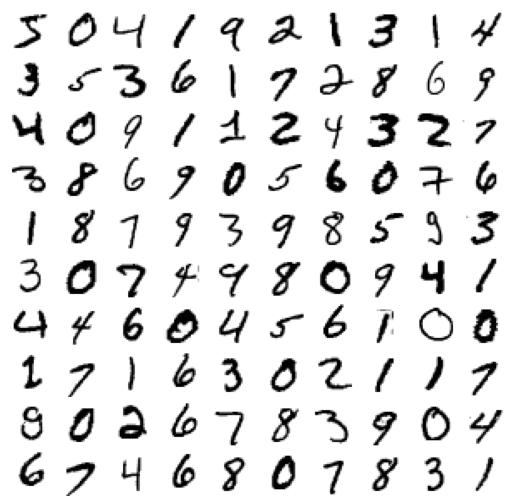

In [3]:
X, y = mnist['data'].values, mnist['target'].values
# The labels are strings, so we cast it to integer
y = y.astype(np.uint8)

# Show the first 100 instances
some_digits = X[:100]

fig, ax = plt.subplots(10, 10, figsize=(9, 9), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, axi in enumerate(ax.flat):
    axi.axis('off')
    im = axi.imshow(X[i].reshape(28, 28), cmap='binary')

The MNIST dataset is already split into a training set (first 60,000) and a test set (last 10,000):

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

We will transform this classification problem into a binary one: we will split the data into two classes, 5 and not-5:

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Let's train a _Stochastic Gradient Descent_ (SGD) on this data:

In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd_clf = SGDClassifier(random_state=42)

# 3 fold cross validation to evaluate the accuracy of the model
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

The model got over 90% accuracy! This might sound impressive at first glance, but not so much if we consider the split between 5 and not-5 digits:

In [7]:
np.count_nonzero(y_train_5) / y_train_5.shape[0]

0.09035

There are roughly 9 times more not-5 digits! This means that a simple classifier that guesses that the digits are never a 5, would get over 90% accuracy! For _skewed datasets_ such as this, the accuracy is not a good metric to measure performance.

## Performance Measures

Let's take a look at the confusion matrix to get a better idea of the model's performance:

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

We can see that the positive class (5) gets confused with the negative class (not-5) quite often! This shows that the model is not that good at distinguishing between both of them as the accuracy would lead us to believe. We can verify this by computing the precision and recall scores:

In [9]:
from sklearn.metrics import precision_score, recall_score

print("Precision score:", precision_score(y_train_5, y_train_pred))
print("Recall score:", recall_score(y_train_5, y_train_pred))

Precision score: 0.8370879772350012
Recall score: 0.6511713705958311


The $F_1$ score is the harmonic mean of precision and recall. Let's see how our model scores:

In [10]:
from sklearn.metrics import f1_score

print("F1 score:", f1_score(y_train_5, y_train_pred))

F1 score: 0.7325171197343846


It doesn't look that great anymore, right?

Another common tool we could use to evaluate this model's performance is the ROC curve! Let's see what it tells us:

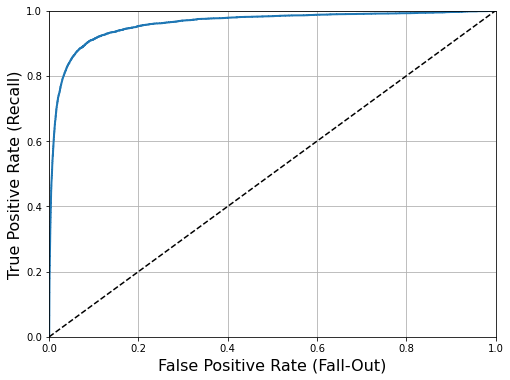

In [11]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)   

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

We can measure the _area under the curve_ (AUC) for a quantitative measure:

In [12]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

We will now train a `RandomForestClassifier` and compare its ROC curve and ROC AUC score to those of the `SGDClassifier`:

In [13]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

With the model trained, we just need to plot the ROC curves:

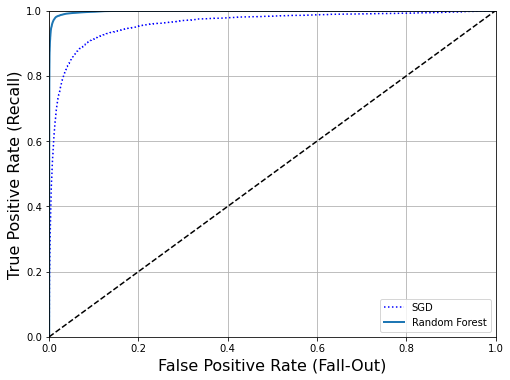

In [14]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b:', label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

We can see that the Random Forest performs much better, as it gets much closer to the perfect spot (upper left corner). Evidently, the ROC AUC score is very high as well:

In [15]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

We can force Scikit-Learn to the use one-versus-one or one-versus-the-rest using the `OneVsOneClassifier` or `OneVsRestClassifier` classes. For example, this is how we would train a SVM using OvR instead of OvO (the default):

In [16]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train[:5000], y_train[:5000])
len(ovr_clf.estimators_)

10